# Bayesian regression, four ways

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

/home/lukas/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/lukas/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## 1. Univariate normal distribution
Let's try to infer the most likely parameters of a normal distribution given some data ($y$).
We'll generate some data (of size $N = 100$) with known parameters $\mu = 0$ and $\sigma = 1$:

\begin{align}
y \sim N(0, 1)
\end{align}

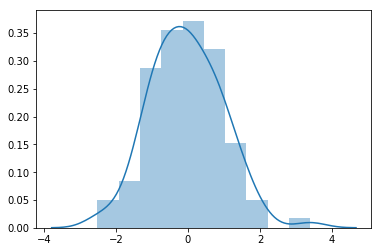

In [2]:
N = 100
y = np.random.normal(0, 1, size=N)

sns.distplot(y)

Now, the analytical (estimated) mean is calculated as:

\begin{align}
\bar{y} = \frac{1}{N}\sum_{i}^{N}y_{i} 
\end{align}

And the analytical standard deviation is calculated as:

\begin{align}
s = \frac{1}{N}\sum_{i}^{N}(y_{i} - \bar{y})^2
\end{align}

Let's do just that:

In [3]:
y_est_mean = np.mean(y)
y_est_sd = np.std(y)

print('Estimated mean: %.3f' % y_est_mean)
print('Estimated sd: %.3f' % y_est_sd)

Estimated mean: -0.044
Estimated sd: 0.999


Now, how about a bayesian estimation?

\begin{align}
p(\theta \mid y) \propto p(y \mid \theta)p(\theta)
\end{align}

Let's use completely flat priors to mimic the analytical solution:

In [4]:
model = pm.Model()

with model:
    
    mu = pm.Flat('mu')
    sigma = pm.Uniform('sigma', lower=0, upper=10**6)
    y_obs = pm.Normal('y_obs', mu=mu, sd=sigma, observed=y)
    trace_ndist = pm.sample(cores=2, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:01<00:00, 1643.99draws/s]
The acceptance probability does not match the target. It is 0.8864102638699515, but should be close to 0.8. Try to increase the number of tuning steps.


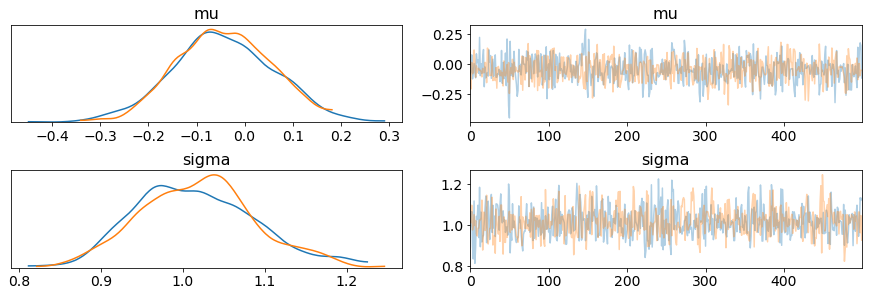

Estimated mean, bayesian: -0.046
Estimated sd, bayesian: 1.016


In [5]:
pm.traceplot(trace_ndist)
plt.show()

y_est_mean_bayes = np.mean(trace_ndist['mu'])
y_est_sd_bayes = np.mean(trace_ndist['sigma'])

print('Estimated mean, bayesian: %.3f' % y_est_mean_bayes)
print('Estimated sd, bayesian: %.3f' % y_est_sd_bayes)

Close enough!

## OLS regression
Now, let's also generate some independent variable, $X$, which we'll use to re-generate our $y$ variable:

\begin{align}
y = X\beta + \epsilon \sim N(0, 1)
\end{align}

In [6]:
X = np.random.normal(0, 1, size=N)
X = np.c_[np.ones(N), X]
epsilon = np.random.normal(0, 2, size=N)
betas = np.array([1, 2])
y = X.dot(betas) + epsilon

Now, let's first estimate the parameters ($\beta$) using the analytical version (OLS):

\begin{align}
\hat{\beta} = (X^{T}X)^{-1}X^{T}y
\end{align}

In [7]:
betas_ols = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
sigmasq_ols = np.sum((y - X.dot(betas_ols)) ** 2) / (N - 2)
covar_betas_ols = sigmasq_ols * np.linalg.inv(X.T.dot(X))
print('Estimated params, OLS: %s' % (betas_ols,))
print('Estimated sigma, OLS: %s' % (sigmasq_ols,))

covar_betas_ols

Estimated params, OLS: [0.94589492 1.72028672]
Estimated sigma, OLS: 3.469590631534988


array([[ 0.03475338, -0.00155882],
       [-0.00155882,  0.04227812]])

And the Bayesian way:

\begin{align}
y \sim N(X\beta, \sigma I)
\end{align}

In [8]:
ols_model = pm.Model()

with ols_model:
    betas_bayes = pm.Flat('betas', shape=2)
    sigma_bayes = pm.Uniform('sigma', lower=0, upper=10**6)
    y_obs = pm.Normal('y_obs', mu=pm.math.dot(X, betas_bayes), sd=sigma_bayes, observed=y)
    trace_ols = pm.sample(10000, cores=2)
    map_est = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, betas]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:08<00:00, 2481.65draws/s]
The acceptance probability does not match the target. It is 0.880414819936321, but should be close to 0.8. Try to increase the number of tuning steps.
/home/lukas/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -216.96, ||grad|| = 1.8463: 100%|██████████| 26/26 [00:00<00:00, 3083.35it/s]          


In [9]:
betas_est_bayes = np.mean(trace_ols['betas'], axis=0)
sd_est_bayes = np.mean(trace_ols['sigma'])
print('Estimated params, bayes: %s' % (betas_est_bayes,))
print('Estimated sd, bayes: %s' % (sd_est_bayes,))

Estimated params, bayes: [0.94740416 1.72164088]
Estimated sd, bayes: 1.8866957146495311


Note that the (co)variance of the posterior distributions of the parameters ($\beta$) is (approximately) the same as the analytical (OLS) solution when assuming a flat prior over the parameters. 

In [10]:
np.cov(trace_ols['betas'].T)

array([[ 0.03559649, -0.0013104 ],
       [-0.0013104 ,  0.04382749]])

Actually, isn't it a multivariate normal distribution of the noise?

In [11]:
ols_model = pm.Model()

with ols_model:
    betas_bayes = pm.Flat('betas', shape=2)
    sigma_bayes = pm.Uniform('sigma', lower=0, upper=10**6)
    cov = sigma_bayes**2 * np.eye(N)
    y_obs = pm.MvNormal('y_obs', mu=pm.math.dot(X, betas_bayes), cov=cov, observed=y)
    trace_ols = pm.sample(2000, cores=2)
    map_est = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/lukas/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/lukas/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/lukas/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

Estimated params, bayes: [0.94632978 1.7226706 ]
Estimated sd, bayes: 1.887824133958095


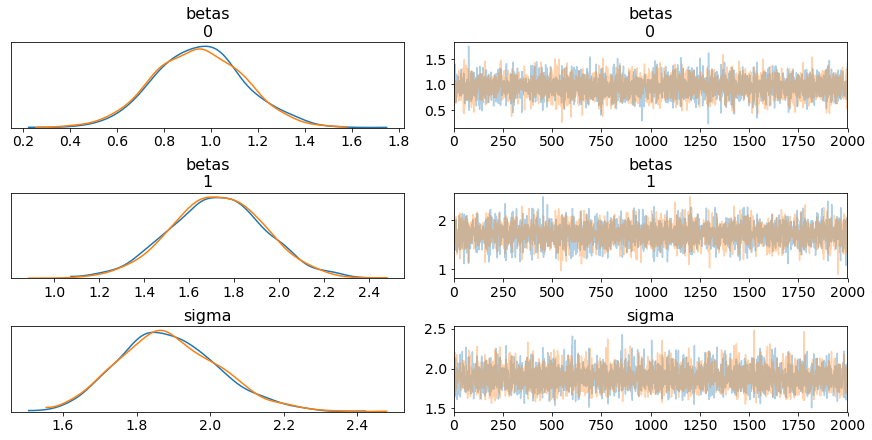

In [12]:
pm.traceplot(trace_ols)
betas_est_bayes = np.mean(trace_ols['betas'], axis=0)
sd_est_bayes = np.mean(trace_ols['sigma'])
print('Estimated params, bayes: %s' % (betas_est_bayes,))
print('Estimated sd, bayes: %s' % (sd_est_bayes,))

Also, it's actually quite easy to run a (bayesian) GLM with OLS-like likelihoods (Gaussian) and priors (flat) using the `glm` module of pymc3:

In [13]:
data = pd.DataFrame({'X1': X[:, 1], 'y': y})
with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ X1', data=data,
                            family='normal',
                            priors=None)
    
    trace = pm.sample(2000, cores=2)

print(np.mean(trace['Intercept'], axis=0))
print(np.mean(trace['X1'], axis=0))
print(np.mean(trace['sd'], axis=0))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, X1, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:01<00:00, 2629.32draws/s]


0.943064141566937
1.7193585947835317
1.8851071151102192


Same same!

## GLS
When the noise cannot be assumed to be independent (i.e., there is autocorrelation), generalized least squares (GLS) is a more efficient estimator than OLS.

In Bayesian terms, we assume that $y$ is distributed as:

\begin{align}
y \sim N(X\beta, \sigma^2 V)
\end{align}

where $V$ is the covariance matrix of the noise, which has non-zero elements.

Suppose that we have found a way to reliably estimate $V$. Now, we can show that the variance of the GLS estimator is less than the OLS estimator:

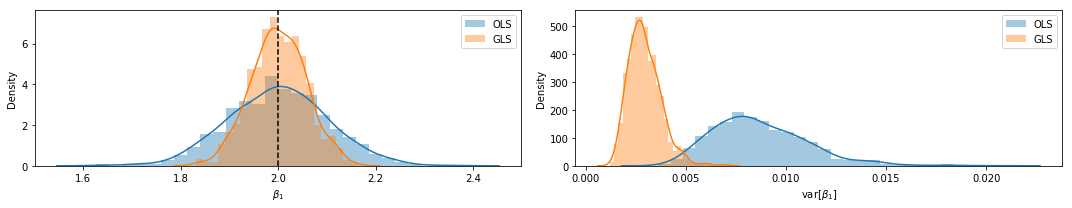

In [14]:
V = 0.75**sp.linalg.toeplitz(np.arange(N))

iters = 1000
betas_ols = np.zeros((iters, 2))
betas_gls = np.zeros((iters, 2))
variance_ols = np.zeros((iters, 2))
variance_gls = np.zeros((iters, 2))

for i in range(iters):
    epsilon = np.random.multivariate_normal(np.zeros(N), cov=V)
    y_gls = X.dot(betas) + epsilon
    betas_ols[i, :] = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y_gls)
    variance_ols[i, :] = np.diagonal(np.sum((y_gls - X.dot(betas_ols[i, :]))**2) / (N - 2) * np.linalg.inv(X.T.dot(X)))
    V_inv = np.linalg.inv(V)
    betas_gls[i, :] = np.linalg.inv(X.T.dot(V_inv).dot(X)).dot(X.T).dot(V_inv).dot(y_gls)
    variance_gls[i, :] = np.diagonal(np.sum((y_gls - X.dot(betas_gls[i, :]))**2) / (N - 2) * np.linalg.inv(X.T.dot(V_inv).dot(X)))
    
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
sns.distplot(betas_ols[:, 1])
sns.distplot(betas_gls[:, 1])
plt.legend(['OLS', 'GLS'])
plt.xlabel(r'$\beta_{1}$')
plt.ylabel('Density')
plt.axvline(betas[1], c='k', ls='--')

plt.subplot(1, 2, 2)
sns.distplot(variance_ols[:, 1])
sns.distplot(variance_gls[:, 1])

plt.legend(['OLS', 'GLS'])
plt.xlabel(r'$\mathrm{var}[\beta_{1}]$')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [15]:
gls_model = pm.Model()
epsilon = np.random.multivariate_normal(np.zeros(N), cov=V)
y_gls = X.dot(betas) + epsilon

with gls_model:
    betas_bayes = pm.Flat('betas', shape=2)
    sigma_bayes = pm.Uniform('sigma', lower=0, upper=10**6)
    cov = sigma_bayes**2 * V
    y_obs = pm.MvNormal('y_obs', mu=pm.math.dot(X, betas_bayes), cov=cov, observed=y_gls)
    trace_gls = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/lukas/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, betas]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:25<00:00, 206.44draws/s]
The acceptance probability does not match the target. It is 0.8862362877891181, but should be close to 0.8. Try to increase the number of tuning steps.


Estimated params, bayes: [0.8053942  2.05094729]
Estimated sd, bayes: 1.0647302668689054


array([[0.07842994, 0.00085599],
       [0.00085599, 0.00352862]])

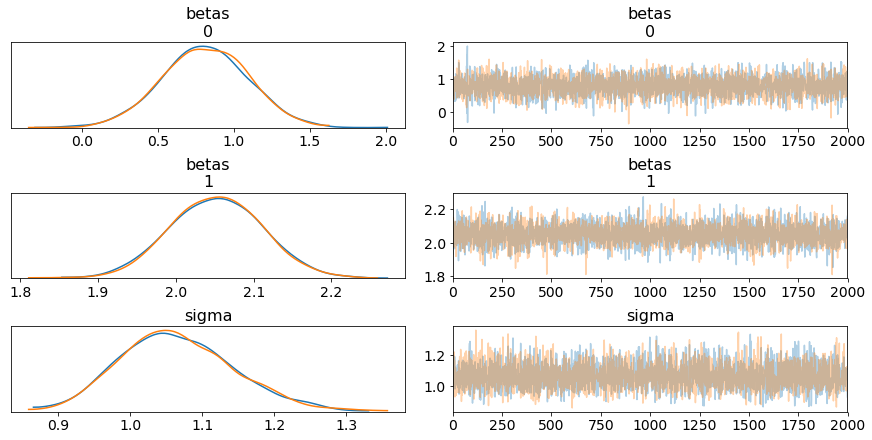

In [16]:
pm.traceplot(trace_gls)
betas_est_bayes = np.mean(trace_gls['betas'], axis=0)
sd_est_bayes = np.mean(trace_gls['sigma'])
var_est_bayes = np.cov(trace_gls['betas'].T)
print('Estimated params, bayes: %s' % (betas_est_bayes,))
print('Estimated sd, bayes: %s' % (sd_est_bayes,))
var_est_bayes

In [17]:
V_inv = np.linalg.inv(V)
betas_gls_est = np.linalg.inv(X.T.dot(V_inv).dot(X)).dot(X.T).dot(V_inv).dot(y_gls)
print(betas_gls_est)
print(sm.GLS(y_gls, X, sigma=V).fit().params)
sigma_sq_gls = np.sum((y_gls - X.dot(betas_gls_est))**2) / (N - 2)
print(np.linalg.inv(X.T.dot(V_inv * sigma_sq_gls).dot(X)))
print(sm.GLS(y_gls, X, sigma=V).fit().cov_params())

[0.80385323 2.04973606]
[0.80385323 2.04973606]
[[0.05381357 0.00033486]
 [0.00033486 0.00254489]]
[[0.07273729 0.00045261]
 [0.00045261 0.0034398 ]]


## Ridge
Ridge regression is regression with an L2 penalization, which has an analytical solution:

\begin{align}
\hat{\beta}_{ridge} = (X^TX+\lambda I)^{-1}X^Ty
\end{align}

It turns out that ridge can be seen as bayesian regression using a normal prior on the parameters ($\beta$) with mean 0 and when $\lambda$ equals $\frac{\sigma^2}{\tau^2}$, where $tau^2$ equals the scale ("sigma") parameters of the normal prior. Rearranging this, the following normal prior on the parameters for any given lambda should give the same results as the "analytical" ridge regression solution:

\begin{align}
p(\beta) = N(0, \frac{\sigma}{\sqrt{\lambda}})
\end{align}

Let's check this out for a range of lambdas:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, sigma]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1272.96draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, sigma]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1682.06draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, sigma]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1394.46draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, sigma]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1387.66draws/s]
The acceptance probability does not match the target. It is 0.8813255499515462, but should be close to 0.8. Try to increase the number o

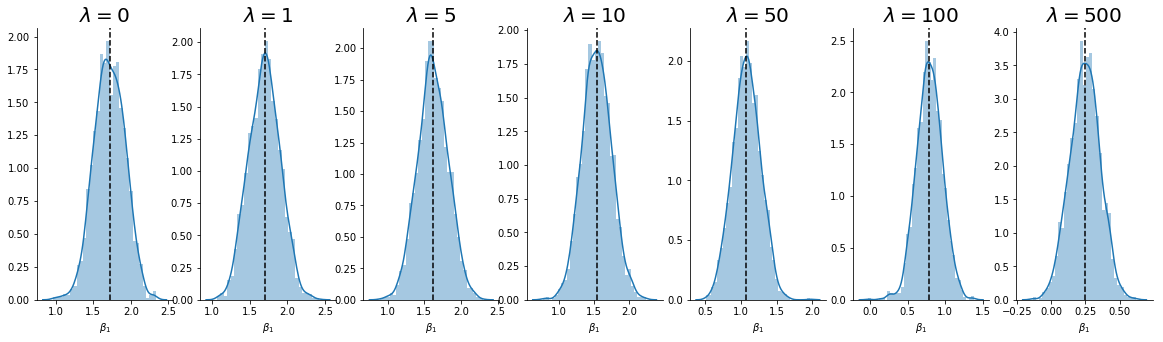

In [125]:
lambds = [1, 5, 10, 50, 100, 500]

fig, axes = plt.subplots(ncols=len(lambds), figsize=(20, 5))

b_ridge = np.zeros(len(lambds))
b_ridge_bayes = np.zeros(len(lambds))
for i, lambd in enumerate(lambds):
    b_ridge = np.linalg.inv(X.T.dot(X) + lambd * np.eye(2)).dot(X.T).dot(y)[1]
    ridge_model = pm.Model()

    with ridge_model:
        sigma_llh = pm.Uniform('sigma', lower=0, upper=10**6)
        sigma_prior = sigma_llh / np.sqrt(lambd)
        betas = pm.Normal('betas', 0, sigma=sigma_prior, shape=(2,))
        y_obs = pm.Normal('y_obs', mu=pm.math.dot(X, betas), sigma=sigma_llh, observed=y)
        trace_ridge = pm.sample(1000, cores=2)
        sns.distplot(trace_ridge['betas'][:, 1], ax=axes[i])
        axes[i].axvline(b_ridge, ls='--', c='k')
        axes[i].set_xlabel(r'$\beta_{1}$')
        axes[i].set_title(r'$\lambda = %i$' % lambd, fontsize=20)
        
sns.despine()

Or with a multivariate normal (spherical) prior:

\begin{align}
\beta \sim MVN(0, \frac{\sigma^2}{\lambda}I)
\end{align}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/lukas/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, sigma]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:11<00:00, 422.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, sigma]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:10<00:00, 481.35draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, sigma]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:

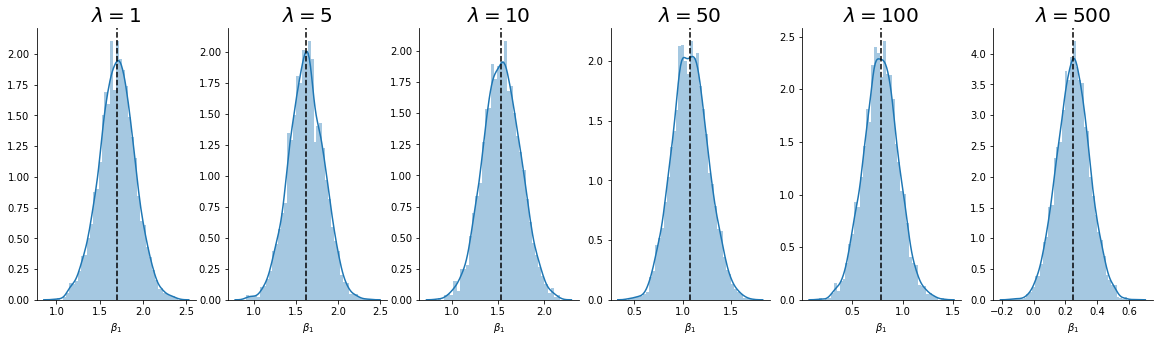

In [77]:
lambds = [1, 5, 10, 50, 100, 500]

fig, axes = plt.subplots(ncols=len(lambds), figsize=(20, 5))

for i, lambd in enumerate(lambds):
    b_ridge = np.linalg.inv(X.T @ X + lambd * np.eye(2)) @ X.T @ y
    ridge_model = pm.Model()

    with ridge_model:
        sigma_llh = pm.Uniform('sigma', lower=0, upper=10**6)
        sigma_prior = (sigma_llh ** 2 / lambd) * np.eye(2)
        betas = pm.MvNormal('betas', np.zeros(2), cov=sigma_prior, shape=(2,))
        y_obs = pm.Normal('y_obs', mu=pm.math.dot(X, betas), sigma=sigma_llh, observed=y)
        trace_ridge = pm.sample(2000, cores=2)
        sns.distplot(trace_ridge['betas'][:, 1], ax=axes[i])
        axes[i].axvline(b_ridge[1], ls='--', c='k')
        axes[i].set_xlabel(r'$\beta_{1}$')
        axes[i].set_title(r'$\lambda = %i$' % lambd, fontsize=20)
        
sns.despine()

## Tikhonov regression
Analytical solution:

\begin{align}
\hat{\beta}_{tikhonov} = (X^TX + \lambda \Sigma^{-1})^{-1}X^Ty
\end{align}

Which is the same as a multivariate normal prior on $\beta$:

\begin{align}
\beta \sim MVN(0, \frac{\sigma^2}{\lambda}\Sigma)
\end{align}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/lukas/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, sigma]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:10<00:00, 480.98draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, sigma]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:10<00:00, 456.97draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, sigma]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:

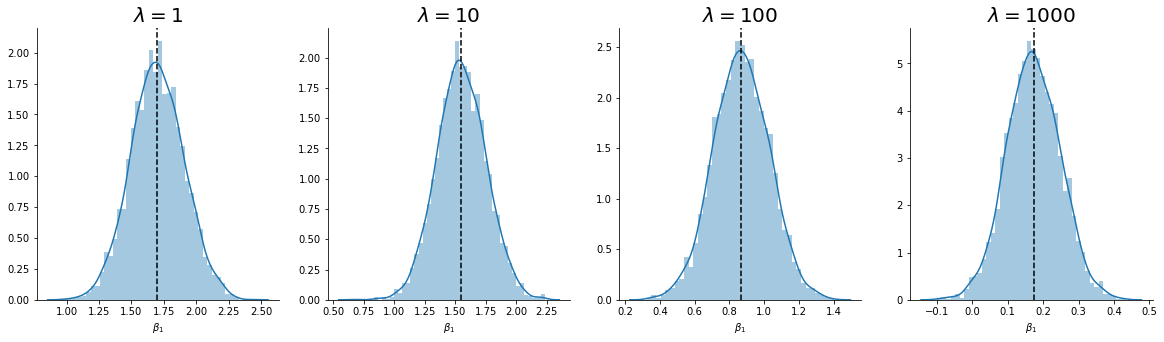

In [78]:
sigma_tik = np.array([
    [1, 0.5],
    [0.5, 1]
])

lambds = [1, 5, 100, 1000]

fig, axes = plt.subplots(ncols=len(lambds), figsize=(20, 5))
for i, lambd in enumerate(lambds):
    b_tik = np.linalg.inv((X.T @ X + lambd * np.linalg.inv(sigma_tik))) @ X.T @ y
    tik_model = pm.Model()

    with tik_model:
        sigma_llh = pm.Uniform('sigma', lower=0, upper=10**6)
        sigma_prior = (sigma_llh ** 2 / lambd) * sigma_tik
        betas = pm.MvNormal('betas', mu=np.zeros(2), cov=sigma_prior, shape=(2,))
        y_obs = pm.Normal('y_obs', mu=pm.math.dot(X, betas), sigma=sigma_llh, observed=y)
        trace_tik = pm.sample(2000, cores=2)
        sns.distplot(trace_tik['betas'][:, 1], ax=axes[i])
        axes[i].axvline(b_tik[1], ls='--', c='k')
        axes[i].set_xlabel(r'$\beta_{1}$')
        axes[i].set_title(r'$\lambda = %i$' % lambd, fontsize=20)

sns.despine()

## LASSO


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, sigma]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1521.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, sigma]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1548.92draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, sigma]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:02<00:00, 1390.47draws/s]
The acceptance probability does not match the target. It is 0.883525250897939, but should be close to 0.8. Try to increase the number of tuning steps.


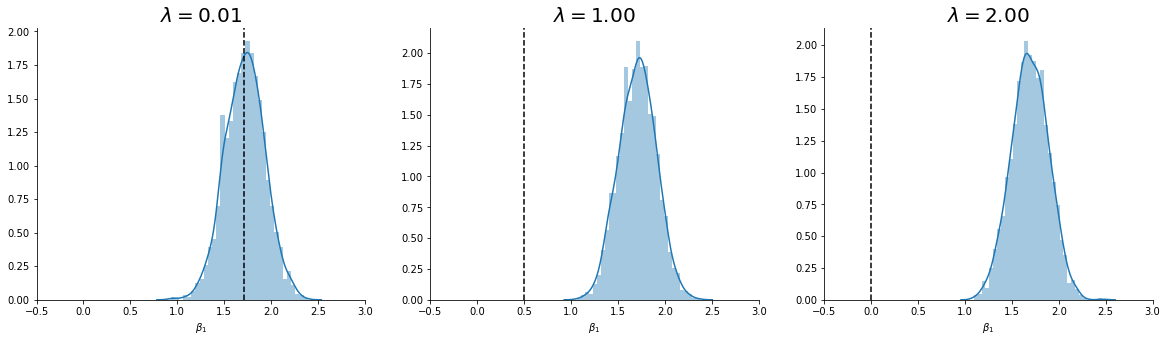

In [124]:
from sklearn.linear_model import Lasso

lambds = [0.01, 1, 2]

fig, axes = plt.subplots(ncols=len(lambds), figsize=(20, 5))
for i, lambd in enumerate(lambds):
    model = Lasso(alpha=lambd)
    b_lasso = model.fit(X, y).coef_

    lasso_model = pm.Model()
    with lasso_model:
        sigma_llh = pm.Uniform('sigma', lower=0, upper=10**6)
        tau_prior = (sigma_llh ** 2) / lambd
        betas = pm.Laplace('betas', 0, tau_prior, shape=(2,))
        y_obs = pm.Normal('y_obs', mu=pm.math.dot(X, betas), sigma=sigma_llh, observed=y)
        trace_lasso = pm.sample(1000, cores=2)
        sns.distplot(trace_lasso['betas'][:, 1], ax=axes[i])
        axes[i].axvline(b_lasso[1], ls='--', c='k')
        axes[i].set_xlabel(r'$\beta_{1}$')
        axes[i].set_title(r'$\lambda = %.2f$' % lambd, fontsize=20)
        axes[i].set_xlim((-0.5, 3))
        
sns.despine()